# Sentiment Analysis on Manglish Tweets

This notebook implements and evaluates multiple machine learning models for sentiment classification on a dataset of Malay-English (Manglish) tweets. The models explored include:

* **NLTK Sentiment Analysis** (Vader)
* **Multinomial Naive Bayes** with TF-IDF features
* **Linear Support Vector Machine (SVM)** with TF-IDF features
* **Logistic Regression** using sentence embeddings from paraphrase-multilingual-MiniLM-L12-v2

Each model is trained on a consistent train-test split to ensure fair comparison. Their performance is evaluated using:

* **Accuracy**
* **Macro-averaged F1 Score**
* **Confusion Matrices**

The three sentiment classes used are: Negative, Neutral, and Positive.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load dataset
data_path = "../data/processed/cleaned_data.csv"
df = pd.read_csv(data_path)

In [3]:
# Split the dataset
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Vectorize data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [5]:
# Generate Sentence Embeddings using MiniLM
model_st = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
X_train_emb = model_st.encode(X_train.tolist(), convert_to_numpy=True, batch_size=64)
X_test_emb = model_st.encode(X_test.tolist(), convert_to_numpy=True, batch_size=64)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**NLTK Sentiment Analysis (Vader)**

In [6]:
# VADER Baseline
vader = SentimentIntensityAnalyzer()
def vader_to_label(text):
    score = vader.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"
y_pred_vader = X_test.apply(vader_to_label)

**Word Vectors + Classifier**

In [7]:
# Classifiers to test
classifiers = {
    "LinearSVC": LinearSVC(),
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

In [8]:
results = {"VADER": y_pred_vader}
metrics = {"VADER": (accuracy_score(y_test, y_pred_vader), f1_score(y_test, y_pred_vader, average="macro"))}
models = {}

In [9]:
# Train classifiers on TF-IDF and MiniLM embeddings
for clf_name, clf in classifiers.items():
    # TF-IDF
    clf.fit(X_train_tfidf, y_train)
    pred_tfidf = clf.predict(X_test_tfidf)
    name_tfidf = f"TF-IDF + {clf_name}"
    results[name_tfidf] = pred_tfidf
    metrics[name_tfidf] = (accuracy_score(y_test, pred_tfidf), f1_score(y_test, pred_tfidf, average="macro"))
    models[name_tfidf] = clf

    # MiniLM
    if clf_name != "MultinomialNB":  # MNB doesn't work well with dense continuous features
        clf_emb = classifiers[clf_name].__class__()
        clf_emb.fit(X_train_emb, y_train)
        pred_emb = clf_emb.predict(X_test_emb)
        name_emb = f"MiniLM + {clf_name}"
        results[name_emb] = pred_emb
        metrics[name_emb] = (accuracy_score(y_test, pred_emb), f1_score(y_test, pred_emb, average="macro"))
        models[name_emb] = clf_emb

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# Save best model
metric_df = pd.DataFrame(metrics, index=["Accuracy", "Macro-F1"]).T
best_model_name = metric_df["Macro-F1"].idxmax()
print(f"Best Model: {best_model_name}\n", metric_df.loc[best_model_name])

# Save model
joblib.dump(models[best_model_name], f"best_model_{best_model_name.replace(' ', '_').replace('+', '_')}.pkl")

Best Model: TF-IDF + LinearSVC
 Accuracy    0.859007
Macro-F1    0.852356
Name: TF-IDF + LinearSVC, dtype: float64


['best_model_TF-IDF___LinearSVC.pkl']

**Results**

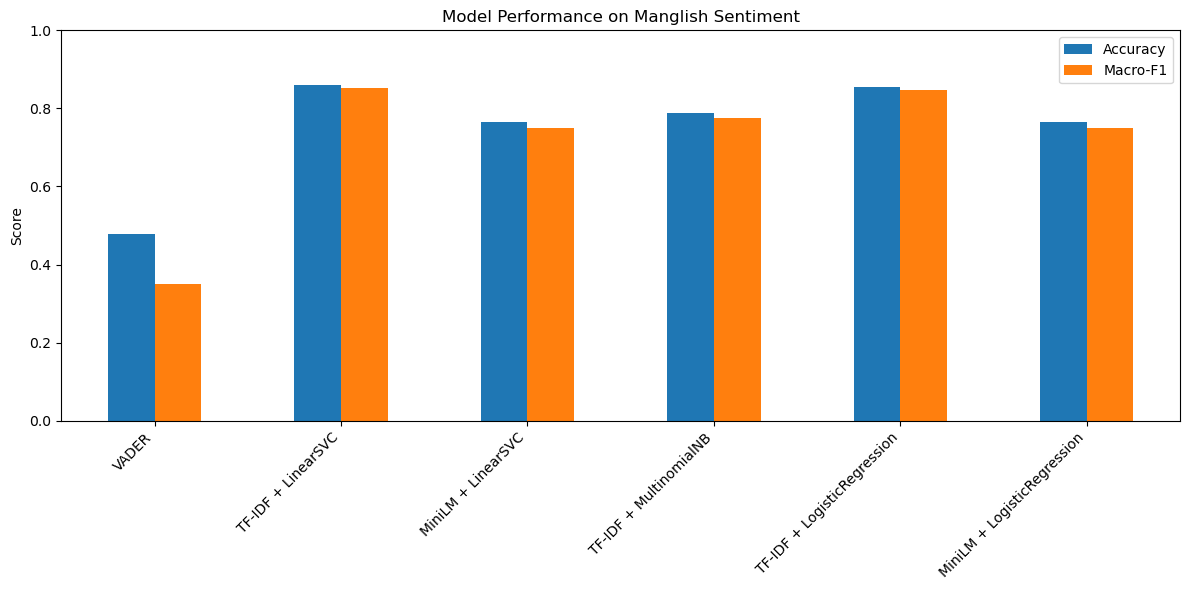

In [11]:
# Plot performance
metric_df.plot(kind="bar", figsize=(12, 6))
plt.title("Model Performance on Manglish Sentiment")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Confusion-matrix heat-maps**

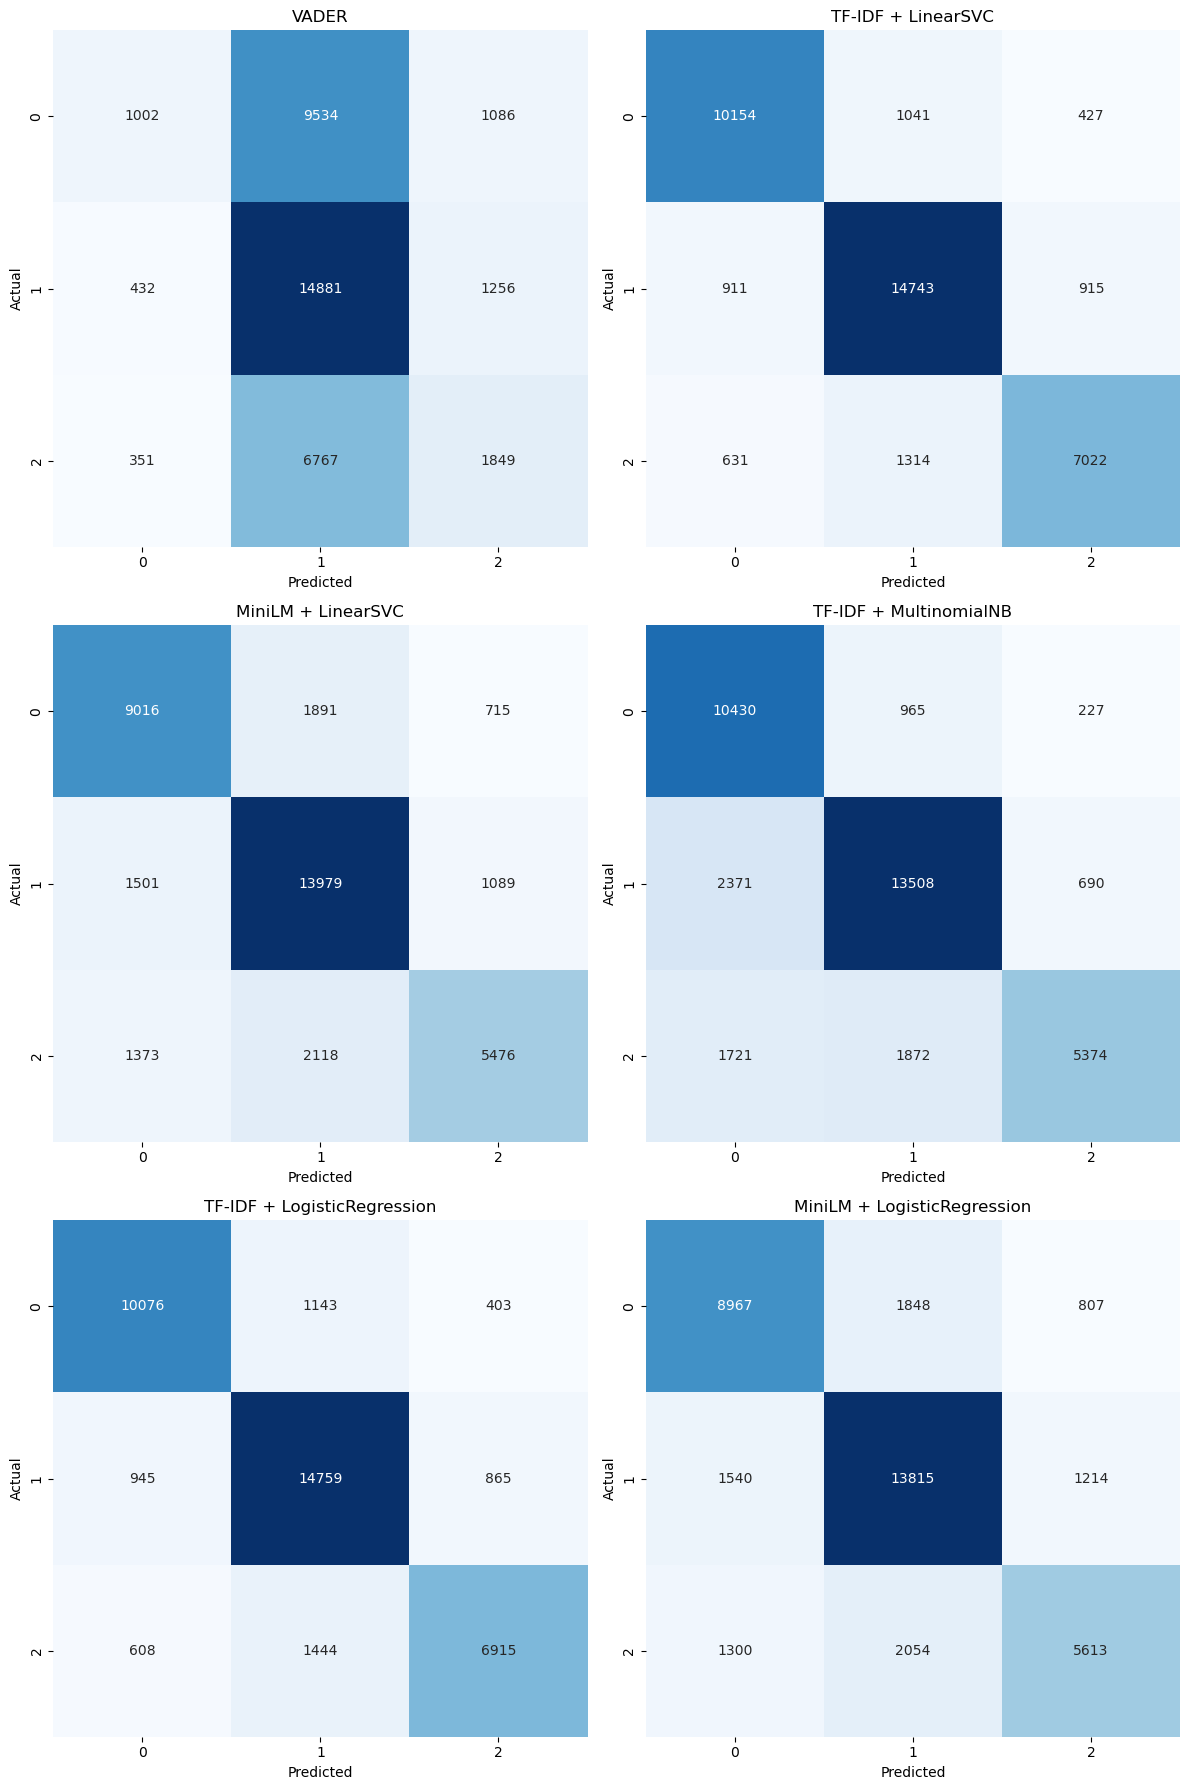

In [14]:
# Confusion matrices
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
axes = axes.flatten()

for ax, (name, preds) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, preds, labels=["Negative", "Neutral", "Positive"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()